In [5]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.5.1
CUDA available: True


In [10]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.5.1
CUDA available: True


  Using cached xgboost-3.2.0-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.3 MB 5.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/11.3 MB 3.4 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.3 MB 3.4 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.3 MB 3.5 MB/s eta 0:00:03
   ------------ --------------------------- 3.7/11.3 MB 3.5 MB/s eta 0:00:03
   --------------- ------------------------ 4.5/11.3 MB 3.6 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.3 MB 3.7 MB/s eta

In [11]:
import xgboost as xgb
print(xgb.__version__)

3.2.0


In [2]:
# ============================================================
# CELL 1 (Plan B - Thesis Version)
# Slice-based splitting:
#   Each unique value of the main variable (txgain / mcs / airtime)
#   is treated as ONE independent slice.
#
# Important:
#   If you want to fully follow thesis logic,
#   your training loop (Cell2) must iterate over slices.
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# 1) Load dataset
# ------------------------------------------------------------
df = pd.read_csv("clean_ul_with_conditions2.csv")

# Target variable
target_col = "pm_power"

# ------------------------------------------------------------
# 2) Define slicing experiments
# ------------------------------------------------------------
EXPERIMENTS = {
    "gain": {
        "slice_col": "txgain",
        "feature_cols": ["selected_mcs", "airtime", "nRBs"]
    },
    "mcs": {
        "slice_col": "selected_mcs", 
        "feature_cols": ["txgain", "airtime", "nRBs"]
    },
    "airtime": {
        "slice_col": "airtime",
        "feature_cols": ["txgain", "selected_mcs", "nRBs"]
    },
}



# ------------------------------------------------------------
# 4) Data cleaning utility
# ------------------------------------------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d

# ------------------------------------------------------------
# 5) Slice-based split function
# ------------------------------------------------------------
def split_within_slice(
    d_slice,
    seed=42,
    train_ratio=0.8,
    val_ratio_within_train=0.1
):
    """
    Perform splitting INSIDE one slice.

    Step 1:
        Split into train and test
            train_ratio (default 80%)
            test_ratio  (default 20%)

    Step 2:
        From train part, split validation set
            val_ratio_within_train (default 10% of train)

    Final proportions (default):
        Train ≈ 72%
        Val   ≈ 8%
        Test  ≈ 20%
    """

    # First split: Train / Test
    train_df, test_df = train_test_split(
        d_slice,
        test_size=(1 - train_ratio),
        random_state=seed
    )

    # Second split: Train / Validation
    train_df, val_df = train_test_split(
        train_df,
        test_size=val_ratio_within_train,
        random_state=seed
    )

    return train_df, val_df, test_df



## Model 1 Config

-EPOCHS = 100
-BATCH_SIZE = 64
-LR = 1e-3
-SEED = 42

In [ ]:
# ============================================================
# CELL 2 (Plan B / Thesis slicing) — Model1 Baseline DNN
#
# Thesis slicing logic:
#   For each experiment (gain / mcs / airtime),
#   each unique value of the main variable is treated as ONE slice.
#   We train ONE model per slice.
#
# Inputs:
#   Use condition features only (COND_FEATURES),
#   because the main variable is fixed inside each slice.
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ------------------------------------------------------------
# 1) Dataset wrapper for PyTorch
# ------------------------------------------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ------------------------------------------------------------
# 2) Baseline DNN (Model 1)
# ------------------------------------------------------------
class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 3) Mean Relative Error (percentage)
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)


# ------------------------------------------------------------
# 4) Train & Eval one slice
# ------------------------------------------------------------
def train_eval_model1_slice(
    train_df,
    val_df,
    test_df,
    feature_cols,
    target_col,
    epochs=200,
    batch_size=64,
    lr=1e-3,
    seed=42,
    verbose_every=10
):
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Extract arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values.astype(float)

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values.astype(float)

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values.astype(float)

    # Standardization (fit only on training)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val_s,   y_val),   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TabularDataset(X_test_s,  y_test),  batch_size=batch_size, shuffle=False)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BaselineDNN(in_dim=len(feature_cols)).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float("inf")
    best_state = None

    # Training loop
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(xb)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * len(xb)
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | Train MSE {train_loss:.6f} | Val MSE {val_loss:.6f}")

    model.load_state_dict(best_state)

    # Test eval
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy().reshape(-1)
            y_pred_list.append(pred)
            y_true_list.append(yb.numpy().reshape(-1))

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": float(mse),
        "rmse": float(rmse),
        "mae": float(mae),
        "mre_pct": float(mre),
        "y_true": y_true,
        "y_pred": y_pred,
        "model": model,
        "scaler": scaler,
    }


# ------------------------------------------------------------
# 5) Thesis slicing experiment loop
# ------------------------------------------------------------
results = []
trained_models_m1_slices = {}     # trained_models_m1_slices[exp_name][slice_value] = {model, scaler}
test_outputs_m1_slices = {}       # optional: store predictions per slice


for exp_name, exp_cfg in EXPERIMENTS.items():
    slice_col    = exp_cfg["slice_col"]
    feature_cols = exp_cfg["feature_cols"]

    print("\n" + "="*70)
    print(f"Experiment: {exp_name} | slice_col = {slice_col}")
    print("="*70)

    #  # Required columns for this experiment ：slice_col + cond features + target
    cols_needed = [slice_col] + feature_cols + [target_col]

     # Clean dataframe (function defined in Cell 1)
    d = clean_numeric_df(df, cols_needed, target_col)

    # Ensure slice_col is numeric (avoid string grouping bugs)
    d[slice_col] = pd.to_numeric(d[slice_col], errors="coerce")
    d = d.dropna(subset=[slice_col]).copy()

    trained_models_m1_slices.setdefault(exp_name, {})
    test_outputs_m1_slices.setdefault(exp_name, {})

    # Train per slice
    for sval, d_slice in d.groupby(slice_col):
        d_slice = d_slice.copy()


        # Split inside slice (function defined in Cell 1)
        train_df, val_df, test_df = split_within_slice(
            d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1
        )

        print(f"\n--- slice {slice_col} = {sval} | sizes: "
              f"train={len(train_df)}, val={len(val_df)}, test={len(test_df)} ---")

        out = train_eval_model1_slice(
            train_df, val_df, test_df,
            feature_cols=exp_cfg["feature_cols"],   
            target_col=target_col,
            epochs=100,
            batch_size=64,
            lr=1e-3,
            seed=42,
            verbose_every=20
        )

        # Save summary metrics
        results.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": float(sval),
            "model": "Model1 (BaselineDNN, slice-wise)",
            "features": ",".join(feature_cols),
            "MSE": out["mse"],
            "RMSE": out["rmse"],
            "MAE": out["mae"],
            "MRE(%)": out["mre_pct"],
            "n_train": len(train_df),
            "n_val": len(val_df),
            "n_test": len(test_df),
        })

        # Save trained objects
        trained_models_m1_slices[exp_name][float(sval)] = {
            "model": out["model"],
            "scaler": out["scaler"]
        }

        # Save test predictions
        test_outputs_m1_slices[exp_name][float(sval)] = {
            "test_df": test_df.copy(),
            "y_true": out["y_true"],
            "y_pred_m1": out["y_pred"],
        }


# Build final results table
results_df = pd.DataFrame(results)

print("\n=== Results (Model1) ===")
display(results_df)

print("\n=== Sorted by MRE(%) ===")
print(results_df.sort_values(["experiment", "MRE(%)"]))



Experiment: gain | slice_col = txgain

--- slice txgain = 20 | sizes: train=36, val=5, test=11 ---
Epoch 001 | Train MSE 119.550331 | Val MSE 119.789513
Epoch 020 | Train MSE 104.179794 | Val MSE 100.893456
Epoch 040 | Train MSE 51.603687 | Val MSE 40.941696
Epoch 060 | Train MSE 8.642183 | Val MSE 9.803376
Epoch 080 | Train MSE 4.655833 | Val MSE 5.406807
Epoch 100 | Train MSE 3.271917 | Val MSE 5.813367

--- slice txgain = 21 | sizes: train=43, val=5, test=12 ---
Epoch 001 | Train MSE 120.069565 | Val MSE 117.821678
Epoch 020 | Train MSE 104.711411 | Val MSE 104.357887
Epoch 040 | Train MSE 51.982529 | Val MSE 54.932137
Epoch 060 | Train MSE 11.227999 | Val MSE 3.725917
Epoch 080 | Train MSE 6.094652 | Val MSE 6.549644
Epoch 100 | Train MSE 3.888842 | Val MSE 3.398905

--- slice txgain = 22 | sizes: train=50, val=6, test=14 ---
Epoch 001 | Train MSE 121.600060 | Val MSE 124.147583
Epoch 020 | Train MSE 105.854706 | Val MSE 107.386826
Epoch 040 | Train MSE 51.872612 | Val MSE 52.9596

,experiment,slice_col,slice_value,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,txgain,20.0,"Model1 (BaselineDNN, slice-wise)","selected_mcs,airtime,nRBs",4.189173,2.046747,1.860271,16.870846,36,5,11
1,gain,txgain,21.0,"Model1 (BaselineDNN, slice-wise)","selected_mcs,airtime,nRBs",9.377769,3.062314,2.473030,21.628107,43,5,12
2,gain,txgain,22.0,"Model1 (BaselineDNN, slice-wise)","selected_mcs,airtime,nRBs",5.490762,2.343238,1.903021,17.056963,50,6,14
3,gain,txgain,23.0,"Model1 (BaselineDNN, slice-wise)","selected_mcs,airtime,nRBs",5.438153,2.331985,1.922742,16.967230,57,7,16
4,gain,txgain,24.0,"Model1 (BaselineDNN, slice-wise)","selected_mcs,airtime,nRBs",4.887289,2.210721,1.741613,15.423166,58,7,17
...,...,...,...,...,...,...,...,...,...,...,...,...
70,airtime,airtime,0.6,"Model1 (BaselineDNN, slice-wise)","txgain,selected_mcs,nRBs",0.116382,0.341148,0.240562,2.033449,367,41,103
71,airtime,airtime,0.7,"Model1 (BaselineDNN, slice-wise)","txgain,selected_mcs,nRBs",0.235939,0.485735,0.295994,2.484939,367,41,103
72,airtime,airtime,0.8,"Model1 (BaselineDNN, slice-wise)","txgain,selected_mcs,nRBs",0.249408,0.499408,0.375275,3.102885,367,41,103
73,airtime,airtime,0.9,"Model1 (BaselineDNN, slice-wise)","txgain,selected_mcs,nRBs",0.150609,0.388083,0.260898,2.100329,367,41,103



=== Sorted by MRE(%) ===
   experiment     slice_col  slice_value                             model  \
74    airtime       airtime          1.0  Model1 (BaselineDNN, slice-wise)   
68    airtime       airtime          0.4  Model1 (BaselineDNN, slice-wise)   
70    airtime       airtime          0.6  Model1 (BaselineDNN, slice-wise)   
64    airtime       airtime          0.0  Model1 (BaselineDNN, slice-wise)   
73    airtime       airtime          0.9  Model1 (BaselineDNN, slice-wise)   
..        ...           ...          ...                               ...   
58        mcs  selected_mcs          9.0  Model1 (BaselineDNN, slice-wise)   
60        mcs  selected_mcs         15.0  Model1 (BaselineDNN, slice-wise)   
61        mcs  selected_mcs         18.0  Model1 (BaselineDNN, slice-wise)   
63        mcs  selected_mcs         23.0  Model1 (BaselineDNN, slice-wise)   
62        mcs  selected_mcs         21.0  Model1 (BaselineDNN, slice-wise)   

                    features       MS


## Model 2 Config

EPOCHS = 400
BATCH_SIZE = 32
LR = 1e-3
WEIGHT_DECAY = 1e-3
DROPOUT = 0.1
SEED = 42
PATIENCE = 30
VERBOSE_EVERY = 20

In [14]:
# ============================================================
# CELL (Plan B / Thesis slicing) — Model2 RegularizedDNN
#
# Thesis slicing logic:
#   For each experiment (gain / mcs / airtime),
#   each unique value of the main variable is ONE slice.
#   Train ONE Model2 per slice.
#
# Inputs:
#   Use condition features only (COND_FEATURES),
#   since the main variable is fixed inside each slice.
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ---------------------------
# Metric: MRE(%)
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)


# ---------------------------
# Model2: RegularizedDNN
# ---------------------------
class RegularizedDNN(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ---------------------------
# Train + Eval one slice
# ---------------------------
def train_eval_model2_slice(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=400, batch_size=32, lr=1e-3, weight_decay=1e-2,
    patience=20, min_delta=0.0,seed=42, verbose_every=20
):
    
     # -------------------------
    # Reproducibility
    # -------------------------
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # -------------------------
    # Extract arrays
    # -------------------------
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values.astype(float)

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values.astype(float)

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values.astype(float)

    print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

    # -------------------------
    # Standardization (fit on train only)
    # -------------------------
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

     # Convert to tensors
    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train,   dtype=torch.float32).view(-1, 1)
    X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,     dtype=torch.float32).view(-1, 1)
    X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,    dtype=torch.float32).view(-1, 1)

    # -------------------------
    # Model setup
    # -------------------------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = RegularizedDNN(input_dim=X_train_s.shape[1], dropout=0.1).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    import copy
    best_val = float("inf")
    best_state = None
    no_improve = 0  

    # -------------------------
    # Training loop
    # -------------------------
    for epoch in range(1, epochs + 1):
        model.train()
        perm = torch.randperm(X_train_t.size(0))
        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            if idx.numel()<2:
                continue
            xb = X_train_t[idx].to(device)
            yb = y_train_t[idx].to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

         # Compute train/val MSE
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_t.to(device))
            val_pred   = model(X_val_t.to(device))
            train_mse  = criterion(train_pred, y_train_t.to(device)).item()
            val_mse    = criterion(val_pred,   y_val_t.to(device)).item()

        # ---- Early stopping (track best by val MSE) ----
        improved = (best_val - val_mse) > min_delta
        if improved:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone()
                        for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stop at epoch {epoch} | best_val={best_val:.6f}")
            break

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

     # Load best checkpoint
    if best_state is not None:
        model.load_state_dict(best_state)

    # -------------------------
    # Test evaluation
    # -------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t.to(device)).cpu().numpy().reshape(-1)

    y_true = y_test_t.numpy().reshape(-1)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": float(mse), "rmse": float(rmse), "mae": float(mae), "mre_pct": float(mre),
        "y_true": y_true, "y_pred": y_pred,
        "scaler": scaler, "model": model
    }


# ============================================================
# Main loop: thesis slicing (per slice_value train 1 model)
# ============================================================

results = []
test_outputs_m2_slices = {}
trained_models_m2_slices = {}

MIN_SLICE_SIZE = 5

for exp_name, exp_cfg in EXPERIMENTS.items():
    slice_col    = exp_cfg["slice_col"]      
    feature_cols = exp_cfg["feature_cols"]

    
    print("\n" + "="*70)
    print(f"[Thesis] Model2 | Experiment: {exp_name} | slice_col={slice_col}")
    print("="*70)

    cols_needed = [slice_col] + feature_cols+ [target_col]
    d = clean_numeric_df(df, cols_needed, target_col)

    d[slice_col] = pd.to_numeric(d[slice_col], errors="coerce")
    d = d.dropna(subset=[slice_col]).copy()

    print("Unique slices:", d[slice_col].nunique())

    trained_models_m2_slices.setdefault(exp_name, {})
    test_outputs_m2_slices.setdefault(exp_name, {})

    for sval, d_slice in d.groupby(slice_col):
        if len(d_slice) < MIN_SLICE_SIZE:
            continue

        # Split inside slice (defined in Cell 1)
        train_df, val_df, test_df = split_within_slice(
            d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1
        )
        if len(train_df) < 10 or len(val_df) < 5 or len(test_df) < 5:
            continue

        print(f"\n--- slice {slice_col}={sval} | sizes: {len(train_df)}/{len(val_df)}/{len(test_df)} ---")

        out = train_eval_model2_slice(
            train_df, val_df, test_df,
            feature_cols = exp_cfg["feature_cols"],
            target_col=target_col,
            epochs=400, batch_size=32, lr=1e-3, weight_decay=1e-2,
            patience =20, min_delta=1e-4,
            seed=42, verbose_every=20
        )

        results.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": float(sval),
            "model": "Model2 (RegularizedDNN, slice-wise)",
            "features": ",".join(feature_cols),
            "MSE": out["mse"],
            "RMSE": out["rmse"],
            "MAE": out["mae"],
            "MRE(%)": out["mre_pct"],
            "n_train": len(train_df),
            "n_val": len(val_df),
            "n_test": len(test_df),
        })

        trained_models_m2_slices[exp_name][float(sval)] = {
            "model": out["model"],
            "scaler": out["scaler"]
        }

        test_outputs_m2_slices[exp_name][float(sval)] = {
            "test_df": test_df.copy(),
            "y_true": out["y_true"],
            "y_pred_m2": out["y_pred"]
        }

results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by experiment + MRE) ===")
print(results_df.sort_values(["experiment", "MRE(%)"]))



[Thesis] Model2 | Experiment: gain | slice_col=txgain
Unique slices: 55

--- slice txgain=20 | sizes: 36/5/11 ---
X_train: (36, 3) X_val: (5, 3) X_test: (11, 3)
Epoch 001 | train MSE 120.258339 | val MSE 121.339905
Epoch 020 | train MSE 105.377037 | val MSE 104.703835
Epoch 040 | train MSE 90.927498 | val MSE 92.194817
Epoch 060 | train MSE 74.812798 | val MSE 77.819206
Epoch 080 | train MSE 61.368523 | val MSE 65.499252
Epoch 100 | train MSE 42.814285 | val MSE 43.249519
Epoch 120 | train MSE 32.754314 | val MSE 33.227196
Epoch 140 | train MSE 22.790476 | val MSE 21.786325
Epoch 160 | train MSE 13.472136 | val MSE 14.710340
Epoch 180 | train MSE 8.921762 | val MSE 8.928896
Epoch 200 | train MSE 4.666484 | val MSE 5.750332
Epoch 220 | train MSE 2.130552 | val MSE 2.234497
Epoch 240 | train MSE 1.356980 | val MSE 1.288436
Epoch 260 | train MSE 1.431369 | val MSE 1.971997
Early stop at epoch 264 | best_val=1.035735

--- slice txgain=21 | sizes: 43/5/12 ---
X_train: (43, 3) X_val: (5, 3)

,experiment,slice_col,slice_value,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,txgain,20.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",1.599981,1.264904,1.170308,10.543718,36,5,11
1,gain,txgain,21.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",1.544363,1.242724,1.148184,9.895494,43,5,12
2,gain,txgain,22.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",0.572940,0.756928,0.681451,6.076946,50,6,14
3,gain,txgain,23.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",0.288990,0.537578,0.460492,4.039930,57,7,16
4,gain,txgain,24.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",0.476522,0.690306,0.487152,4.440137,58,7,17
...,...,...,...,...,...,...,...,...,...,...,...,...
70,airtime,airtime,0.6,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.148880,0.385850,0.270509,2.273210,367,41,103
71,airtime,airtime,0.7,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.372894,0.610650,0.319403,2.671804,367,41,103
72,airtime,airtime,0.8,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.371916,0.609849,0.463191,3.768946,367,41,103
73,airtime,airtime,0.9,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.261620,0.511488,0.336066,2.687051,367,41,103



=== Summary (sorted by experiment + MRE) ===
   experiment     slice_col  slice_value                                model  \
74    airtime       airtime          1.0  Model2 (RegularizedDNN, slice-wise)   
64    airtime       airtime          0.0  Model2 (RegularizedDNN, slice-wise)   
70    airtime       airtime          0.6  Model2 (RegularizedDNN, slice-wise)   
71    airtime       airtime          0.7  Model2 (RegularizedDNN, slice-wise)   
65    airtime       airtime          0.1  Model2 (RegularizedDNN, slice-wise)   
..        ...           ...          ...                                  ...   
55        mcs  selected_mcs          0.0  Model2 (RegularizedDNN, slice-wise)   
61        mcs  selected_mcs         18.0  Model2 (RegularizedDNN, slice-wise)   
60        mcs  selected_mcs         15.0  Model2 (RegularizedDNN, slice-wise)   
62        mcs  selected_mcs         21.0  Model2 (RegularizedDNN, slice-wise)   
63        mcs  selected_mcs         23.0  Model2 (RegularizedDN

## Model 3

In [ ]:
# ============================================================
# Model3 (Paper-aligned) — Slice-wise
#
# 
#   Phase 1: train ThesisDNN (587→261→186→99→16→1)
#            MSE loss + L2 (weight_decay=0.01)，无 Dropout/BN
#            
#   Phase 2: extract 16 维 bottleneck embeddings
#            XGBoost(embeddings → y)
#            : max_depth=5, T=256, eta=0.22
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb

# ---------------------------
# 0) Seed
# ---------------------------
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# ---------------------------
# 1) Metrics
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-3):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)

def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)
    return {"MSE": float(mse), "RMSE": rmse, "MAE": float(mae), "MRE(%)": float(mre)}

# ---------------------------
# 2) Feature engineering
# ---------------------------
def add_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    def has(*cols): return all(c in d.columns for c in cols)

    if has("txgain", "airtime"):
        d["txgain_x_airtime"] = d["txgain"] * d["airtime"]
    if has("selected_mcs", "airtime"):
        d["mcs_x_airtime"] = d["selected_mcs"] * d["airtime"]
    if has("mean_snr", "bler"):
        d["snr_per_bler"] = d["mean_snr"].astype(float) / (d["bler"].astype(float) + 1e-6)
    if has("thr", "selected_airtime"):
        d["thr_per_airtime"] = d["thr"].astype(float) / (d["selected_airtime"].astype(float) + 1e-6)
    elif has("thr", "airtime"):
        d["thr_per_airtime"] = d["thr"].astype(float) / (d["airtime"].astype(float).clip(lower=0.01) + 1e-6)
    if has("mean_snr", "rssi_mean"):
        d["snr_minus_rssi"] = d["mean_snr"] - d["rssi_mean"]
    if has("overflows", "underflows", "lates"):
        d["sched_issues"] = (d["overflows"].astype(float)
                             + d["underflows"].astype(float)
                             + d["lates"].astype(float))
    return d

# ---------------------------
# 3) Clean numeric
# ---------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d

# ---------------------------
# 4) Winsorize — fit on train, apply to val/test
# ---------------------------
def winsorize_fit(X_train, lower_pct=1, upper_pct=99):
    bounds = []
    X_w = X_train.copy().astype(float)
    for j in range(X_train.shape[1]):
        lo = np.percentile(X_w[:, j], lower_pct)
        hi = np.percentile(X_w[:, j], upper_pct)
        if hi > lo:
            X_w[:, j] = np.clip(X_w[:, j], lo, hi)
        bounds.append((lo, hi))
    return X_w, bounds

def winsorize_transform(X, bounds):
    X_w = X.copy().astype(float)
    for j, (lo, hi) in enumerate(bounds):
        if hi > lo:
            X_w[:, j] = np.clip(X_w[:, j], lo, hi)
    return X_w

# ---------------------------
# 5) Dataset
# ---------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)
    def __len__(self):            return len(self.X)
    def __getitem__(self, idx):   return self.X[idx], self.y[idx]

# ---------------------------
# 6) DNN 
#    4 dense layers: 587→261→186→99 + ReLU
#    Bottleneck: 16 neurons (linear)
#    Head: ReLU(bottleneck) → 1
#    L2 正则: weight_decay=0.01 (λ=0.01)
#    无 Dropout / BatchNorm
# ---------------------------
class ThesisDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1        = nn.Linear(input_dim, 587)
        self.fc2        = nn.Linear(587, 261)
        self.fc3        = nn.Linear(261, 186)
        self.fc4        = nn.Linear(186, 99)
        self.bottleneck = nn.Linear(99, 16)   # 16-dim embedding layer
        self.head       = nn.Linear(16, 1)

    def forward(self, x):
        h   = F.relu(self.fc1(x))
        h   = F.relu(self.fc2(h))
        h   = F.relu(self.fc3(h))
        h   = F.relu(self.fc4(h))
        emb = self.bottleneck(h)              # raw 16-dim embeddings (no activation)
        out = self.head(F.relu(emb))          # prediction head uses relu on embeddings
        return out, emb

# ---------------------------
# 7) Phase 1: DNN
# ---------------------------
def train_dnn(
    X_train_s, y_train,
    X_val_s,   y_val,
    input_dim,
    epochs       = 400,
    batch_size   = 32,
    lr           = 1e-3,
    weight_decay = 0.01,    # L2 λ=0.01 
    patience     = 40,
    verbose_every= 50,
    seed         = 42
):
    set_seed(seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = DataLoader(
        TabularDataset(X_train_s, y_train),
        batch_size=batch_size, shuffle=True, drop_last=False
    )

    model     = ThesisDNN(input_dim=input_dim).to(device)
    loss_fn   = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    X_val_t = torch.tensor(X_val_s, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val,   dtype=torch.float32).reshape(-1, 1).to(device)

    best_val, best_state, no_improve = float("inf"), None, 0

    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred, _ = model(xb)
            loss_fn(pred, yb).backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred, _ = model(X_val_t)
            val_loss = loss_fn(val_pred, y_val_t).item()

        if val_loss < best_val:
            best_val   = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"  DNN Epoch {epoch:03d} | val_MSE={val_loss:.6f} | no_improve={no_improve}")

        if no_improve >= patience:
            print(f"  Early stop @ epoch {epoch} | best_val_MSE={best_val:.6f}")
            break

    model.load_state_dict(best_state)
    return model

# ---------------------------
# 8) Phase 2: freeze DNN，extract 16 维 embeddings
# ---------------------------
@torch.no_grad()
def extract_embeddings(model, X_s, batch_size=512):
    # freeze
    for p in model.parameters():
        p.requires_grad_(False)
    model.eval()

    device = next(model.parameters()).device
    X_t    = torch.tensor(X_s, dtype=torch.float32)
    embs   = []
    for i in range(0, len(X_t), batch_size):
        _, emb = model(X_t[i:i + batch_size].to(device))
        embs.append(emb.cpu().numpy())
    return np.vstack(embs)

# ---------------------------
# 9) Phase 3: XGBoost on embeddings → y
#     max_depth=5, T=256, eta=0.22
# ---------------------------
def train_xgb_on_embeddings(emb_train, y_train, emb_val, y_val, seed=42):
    params = {
        "objective":        "reg:squarederror",
        "eval_metric":      "rmse",
        "eta":              0.22,        # η=0.22 
        "max_depth":        5,           # d=5  
        "subsample":        0.85,
        "colsample_bytree": 0.9,
        "min_child_weight": 3,
        "lambda":           1.0,
        "alpha":            0.1,
        "seed":             seed,
        "tree_method":      "hist",
        "device":           "cuda" if torch.cuda.is_available() else "cpu",
    }
    dtrain = xgb.DMatrix(emb_train, label=y_train)
    dval   = xgb.DMatrix(emb_val,   label=y_val)

    booster = xgb.train(
        params           = params,
        dtrain           = dtrain,
        num_boost_round  = 256,          # T=256 
        evals            = [(dval, "val")],
        early_stopping_rounds = 30,
        verbose_eval     = False
    )
    return booster

# ---------------------------
# 10) slice
# ---------------------------
def train_eval_one_slice(
    d_slice,
    feature_cols,
    target_col,
    seed         = 42,
    dnn_epochs   = 400,
    dnn_patience = 40,
    batch_size   = 32,
    lr           = 1e-3,
    verbose_every= 50,
):
    set_seed(seed)

    # 80/10/10 split 
    train_df, val_df, test_df = split_within_slice(
        d_slice, seed=seed, train_ratio=0.8, val_ratio_within_train=0.1
    )

    X_train_raw = train_df[feature_cols].values.astype(float)
    y_train     = train_df[target_col].values.astype(float)
    X_val_raw   = val_df[feature_cols].values.astype(float)
    y_val       = val_df[target_col].values.astype(float)
    X_test_raw  = test_df[feature_cols].values.astype(float)
    y_test      = test_df[target_col].values.astype(float)

    # Winsorize (fit on train)
    X_train_w, bounds = winsorize_fit(X_train_raw)
    X_val_w           = winsorize_transform(X_val_raw,  bounds)
    X_test_w          = winsorize_transform(X_test_raw, bounds)

    # Standardize (fit on train)
    scaler    = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_w)
    X_val_s   = scaler.transform(X_val_w)
    X_test_s  = scaler.transform(X_test_w)

    # Phase 1: train DNN
    dnn = train_dnn(
        X_train_s, y_train,
        X_val_s,   y_val,
        input_dim    = X_train_s.shape[1],
        epochs       = dnn_epochs,
        batch_size   = batch_size,
        lr           = lr,
        weight_decay = 0.01,
        patience     = dnn_patience,
        verbose_every= verbose_every,
        seed         = seed,
    )

    # Phase 2: freeze DNN，extract 16 维 bottleneck embeddings
    emb_train = extract_embeddings(dnn, X_train_s)
    emb_val   = extract_embeddings(dnn, X_val_s)
    emb_test  = extract_embeddings(dnn, X_test_s)

    print(f"  Embedding shape: train={emb_train.shape}, val={emb_val.shape}, test={emb_test.shape}")

    # Phase 3: XGBoost (embeddings → y)
    booster = train_xgb_on_embeddings(
        emb_train, y_train,
        emb_val,   y_val,
        seed=seed
    )

    # final、predict
    y_pred = booster.predict(xgb.DMatrix(emb_test))
    
    y_pred = np.clip(y_pred, y_train.min() * 0.95, y_train.max() * 1.05)

    metrics = compute_metrics(y_test, y_pred)
    return {
        "metrics":  metrics,
        "n_train":  len(train_df) + len(val_df),   # 与 M1/M2 n_train 
        "n_val":    len(val_df),
        "n_test":   len(test_df),
        "d_test":   test_df.copy(),
        "dnn":      dnn,
        "booster":  booster,
        "scaler":   scaler,
        "y_true":   y_test,
        "y_pred":   y_pred,
    }

# ============================================================
# Main loop
# ============================================================

df_fe = add_feature_engineering(df)

EXPERIMENTS = {
    "gain":    {"slice_col": "txgain",       "feature_cols": ["selected_mcs", "airtime", "nRBs"]},
    "mcs":     {"slice_col": "selected_mcs", "feature_cols": ["txgain", "airtime", "nRBs"]},
    "airtime": {"slice_col": "airtime",      "feature_cols": ["txgain", "selected_mcs", "nRBs"]},
}

ENGINEERED = [
    "txgain_x_airtime",
    "mcs_x_airtime",
    "snr_per_bler",
    "thr_per_airtime",
    "snr_minus_rssi",
    "sched_issues",
]

MIN_SLICE_SIZE = 30
SEED           = 42

all_rows          = []
test_outputs_m3B  = {}
trained_models_m3B= {}

for exp_name, exp_cfg in EXPERIMENTS.items():
    slice_col    = exp_cfg["slice_col"]
    feature_cols = exp_cfg["feature_cols"].copy()

    if slice_col not in df_fe.columns:
        print(f"[Skip] {exp_name}: '{slice_col}' not in df")
        continue

    
    feature_cols += [c for c in ENGINEERED if c in df_fe.columns]

    cols_needed = feature_cols + [slice_col, target_col]
    d0 = clean_numeric_df(df_fe, cols_needed, target_col)

    print("\n" + "=" * 60)
    print(f"[Model3] Experiment: {exp_name} | slice_col={slice_col}")
    print(f"Features ({len(feature_cols)}): {feature_cols}")
    print("=" * 60)

    test_outputs_m3B.setdefault(exp_name,   {})
    trained_models_m3B.setdefault(exp_name, {})

    for sval, d_slice in d0.groupby(slice_col):
        if len(d_slice) < MIN_SLICE_SIZE:
            continue

        print(f"\n--- slice {slice_col}={sval} | n={len(d_slice)} ---")

        out = train_eval_one_slice(
            d_slice      = d_slice,
            feature_cols = feature_cols,
            target_col   = target_col,
            seed         = SEED,
            dnn_epochs   = 400,
            dnn_patience = 40,
            batch_size   = 32,
            lr           = 1e-3,
            verbose_every= 50,
        )

        m = out["metrics"]
        all_rows.append({
            "experiment":  exp_name,
            "slice_col":   slice_col,
            "slice_value": sval,
            "features":    ",".join(feature_cols),
            "MSE":         m["MSE"],
            "RMSE":        m["RMSE"],
            "MAE":         m["MAE"],
            "MRE(%)":      m["MRE(%)"],
            "n_train":     out["n_train"],
            "n_test":      out["n_test"],
            "n_slice":     len(d_slice),
        })

        test_outputs_m3B[exp_name][sval] = {
            "test_df":    out["d_test"].copy(),
            "y_true":     out["y_true"],
            "y_pred_m3B": out["y_pred"],
        }

        trained_models_m3B[exp_name][sval] = {
            "dnn":          out["dnn"],
            "booster":      out["booster"],
            "scaler":       out["scaler"],
            "feature_cols": feature_cols,
        }

results_slices_df = pd.DataFrame(all_rows)
print("\n===== Model3 Results =====")
display(results_slices_df.sort_values(["experiment", "slice_value"]))
print("\n===== Sorted by MRE(%) =====")
print(results_slices_df.sort_values("MRE(%)").to_string())



[Model3] Experiment: gain | slice_col=txgain
Features (9): ['selected_mcs', 'airtime', 'nRBs', 'txgain_x_airtime', 'mcs_x_airtime', 'snr_per_bler', 'thr_per_airtime', 'snr_minus_rssi', 'sched_issues']

--- slice txgain=20 | n=52 ---
  DNN Epoch 001 | val_MSE=124.528152 | no_improve=0
  DNN Epoch 050 | val_MSE=2.639634 | no_improve=5
  DNN Epoch 100 | val_MSE=0.787431 | no_improve=2
  DNN Epoch 150 | val_MSE=0.383539 | no_improve=15
  DNN Epoch 200 | val_MSE=0.202092 | no_improve=24
  DNN Epoch 250 | val_MSE=0.242626 | no_improve=6
  DNN Epoch 300 | val_MSE=0.196897 | no_improve=37
  Early stop @ epoch 303 | best_val_MSE=0.118607
  Embedding shape: train=(36, 16), val=(5, 16), test=(11, 16)

--- slice txgain=21 | n=60 ---
  DNN Epoch 001 | val_MSE=121.556145 | no_improve=0
  DNN Epoch 050 | val_MSE=2.903695 | no_improve=0
  DNN Epoch 100 | val_MSE=0.086335 | no_improve=4
  DNN Epoch 150 | val_MSE=0.060906 | no_improve=11
  DNN Epoch 200 | val_MSE=0.046917 | no_improve=8
  DNN Epoch 250

,experiment,slice_col,slice_value,features,MSE,RMSE,MAE,MRE(%),n_train,n_test,n_slice
64,airtime,airtime,0.0,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.166890,0.408521,0.183461,1.672988,427,107,534
65,airtime,airtime,0.1,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.175647,0.419102,0.271149,2.496458,429,108,537
66,airtime,airtime,0.2,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.107723,0.328212,0.251444,2.311731,432,108,540
67,airtime,airtime,0.3,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.118537,0.344293,0.271434,2.458147,435,109,544
68,airtime,airtime,0.4,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.138252,0.371822,0.272321,2.375437,412,103,515
...,...,...,...,...,...,...,...,...,...,...,...
59,mcs,selected_mcs,12.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.074622,0.273170,0.220140,1.937763,468,117,585
60,mcs,selected_mcs,15.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.111149,0.333390,0.240807,2.084100,450,113,563
61,mcs,selected_mcs,18.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.136446,0.369386,0.269688,2.301774,438,110,548
62,mcs,selected_mcs,21.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.146738,0.383064,0.289610,2.459126,431,108,539



===== Sorted by MRE(%) =====
   experiment     slice_col  slice_value                                                                                                           features       MSE      RMSE       MAE    MRE(%)  n_train  n_test  n_slice
74    airtime       airtime          1.0   txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_x_airtime,snr_per_bler,thr_per_airtime,snr_minus_rssi,sched_issues  0.052170  0.228408  0.153012  1.234729      408     103      511
58        mcs  selected_mcs          9.0        txgain,airtime,nRBs,txgain_x_airtime,mcs_x_airtime,snr_per_bler,thr_per_airtime,snr_minus_rssi,sched_issues  0.054908  0.234326  0.172330  1.531970      481     121      602
57        mcs  selected_mcs          6.0        txgain,airtime,nRBs,txgain_x_airtime,mcs_x_airtime,snr_per_bler,thr_per_airtime,snr_minus_rssi,sched_issues  0.054670  0.233815  0.184389  1.629794      484     121      605
56        mcs  selected_mcs          3.0        txgain,airtime,nRBs,txgain_x_airti

In [10]:
print("Model1 airtime keys:", sorted(test_outputs_m1_slices["airtime"].keys()))
print("Model2 airtime keys:", sorted(test_outputs_m2_slices["airtime"].keys()))
print("Model3 airtime keys:", sorted(test_outputs_m3B["airtime"].keys()))

Model1 airtime keys: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Model2 airtime keys: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Model3 airtime keys: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [18]:
print("Model1 mcs keys:", sorted(test_outputs_m1_slices["mcs"].keys()))
print("Model2 mcs keys:", sorted(test_outputs_m2_slices["mcs"].keys()))
print("Model3 mcs keys:", sorted(test_outputs_m3B["mcs"].keys()))

Model1 mcs keys: [0.0, 3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 23.0]
Model2 mcs keys: [0.0, 3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 23.0]
Model3 mcs keys: [0, 3, 6, 9, 12, 15, 18, 21, 23]


In [ ]:
print("Model1 txgain keys:", sorted(test_outputs_m1_slices["gain"].keys()))
print("Model2 txgain keys:", sorted(test_outputs_m2_slices["gain"].keys()))
print("Model3 txgain keys:", sorted(test_outputs_m3B["gain"].keys()))

Model1 txgain keys: [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0]
Model2 txgain keys: [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0]
Model3 txgain keys: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]


: 

(exp_name, xcol, test_outputs_m1B, test_outputs_m2B, test_outputs_m3B)


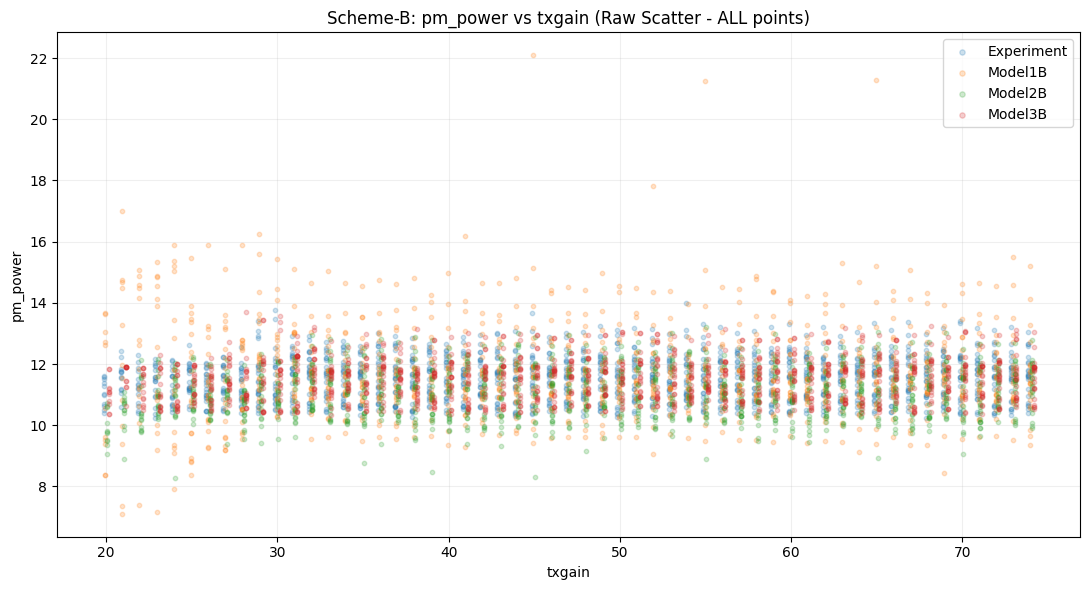

Scheme-B: pm_power vs txgain (Raw Scatter - ALL points)
Total points plotted (raw): 1158
[Model1B] MSE=2.1768 RMSE=1.4754 MAE=1.0798 MRE=9.41%
[Model2B] MSE=0.4588 RMSE=0.6773 MAE=0.5423 MRE=4.68%
[Model3B] MSE=0.3100 RMSE=0.5568 MAE=0.3891 MRE=3.39%


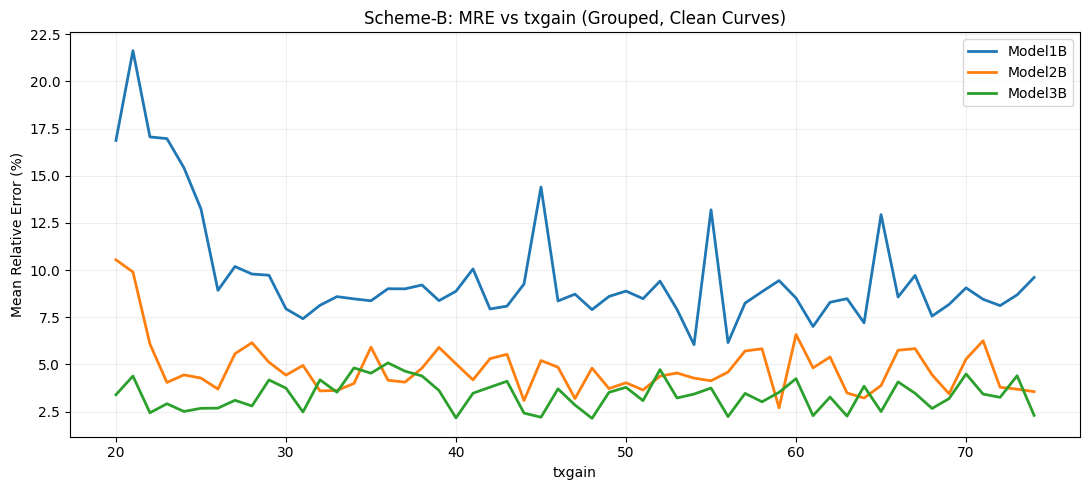

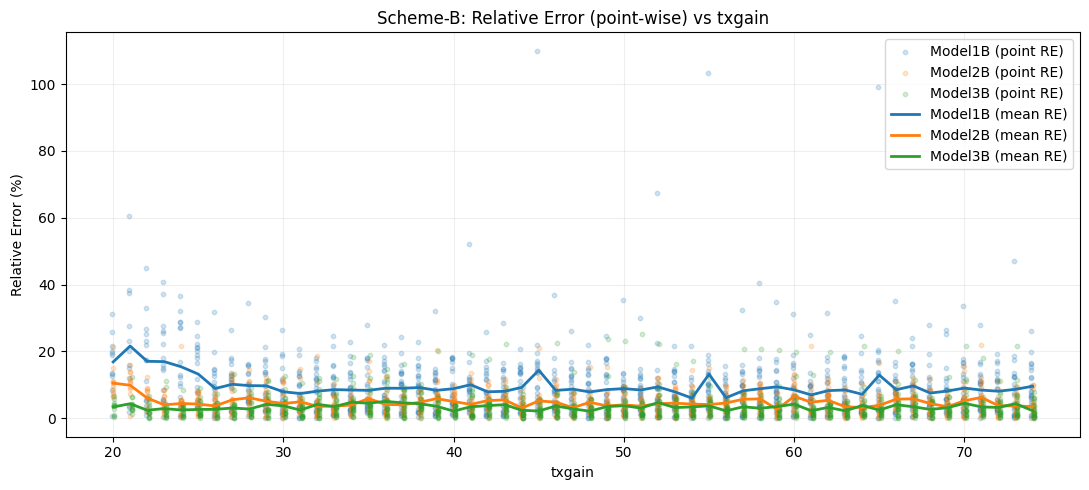

Scheme-B: Relative Error (point-wise) vs txgain
Total points: 1158
Point-RE mean:   M1=9.41% | M2=4.68% | M3=3.39%
Point-RE median: M1=7.57% | M2=4.03% | M3=2.53%


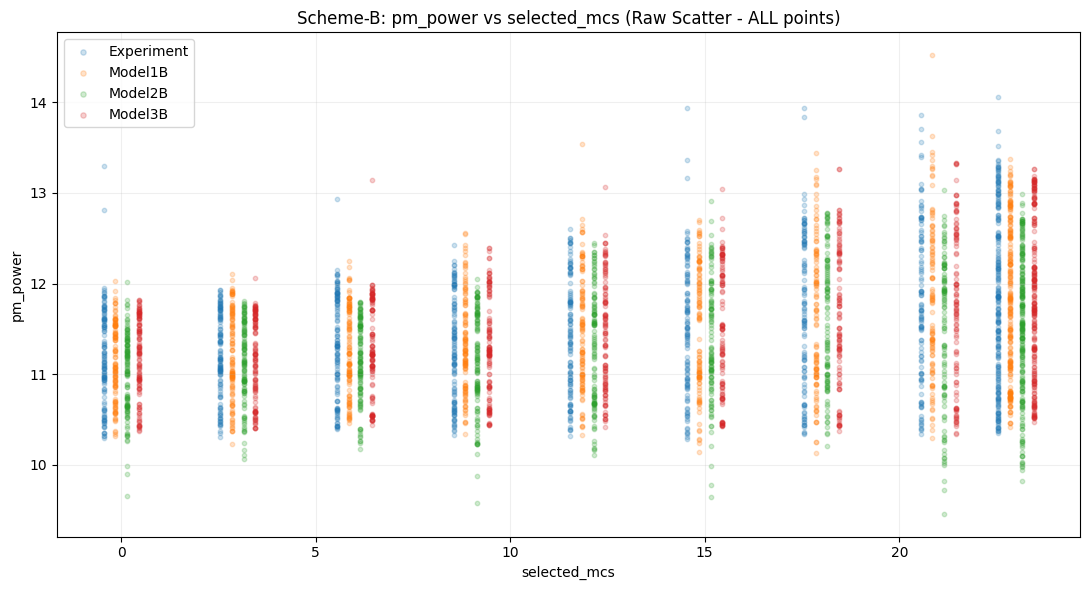

Scheme-B: pm_power vs selected_mcs (Raw Scatter - ALL points)
Total points plotted (raw): 1156
[Model1B] MSE=0.1124 RMSE=0.3353 MAE=0.2454 MRE=2.12%
[Model2B] MSE=0.1852 RMSE=0.4303 MAE=0.3211 MRE=2.75%
[Model3B] MSE=0.1077 RMSE=0.3281 MAE=0.2333 MRE=2.02%


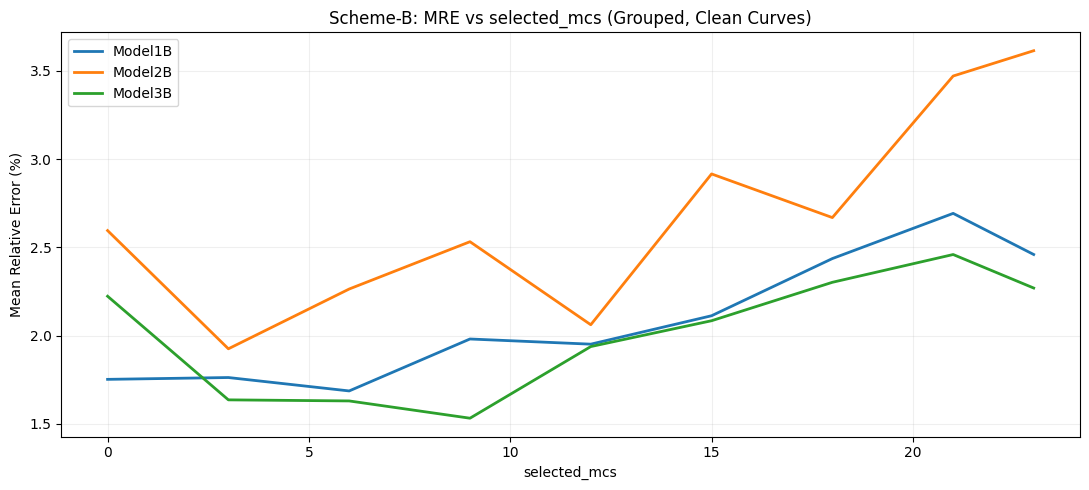

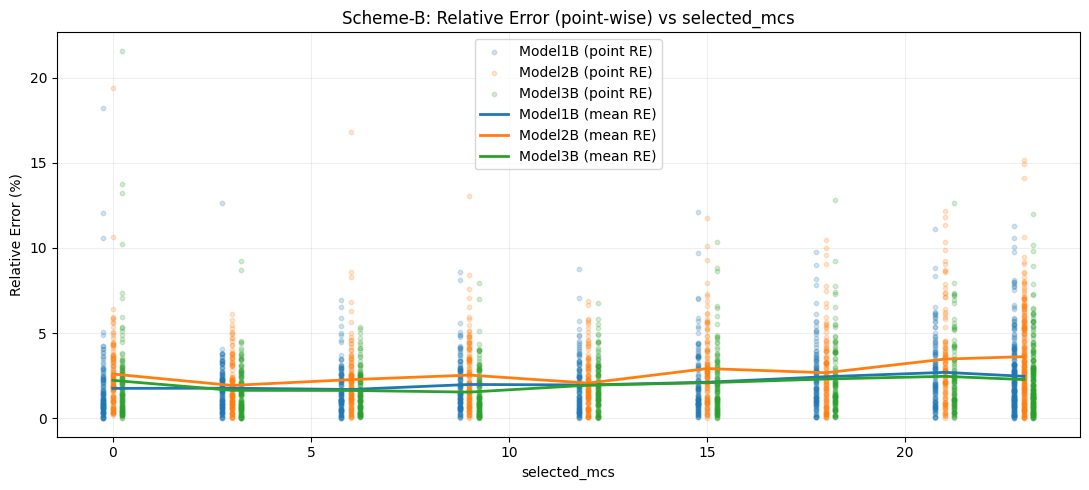

Scheme-B: Relative Error (point-wise) vs selected_mcs
Total points: 1156
Point-RE mean:   M1=2.12% | M2=2.75% | M3=2.02%
Point-RE median: M1=1.64% | M2=2.21% | M3=1.47%


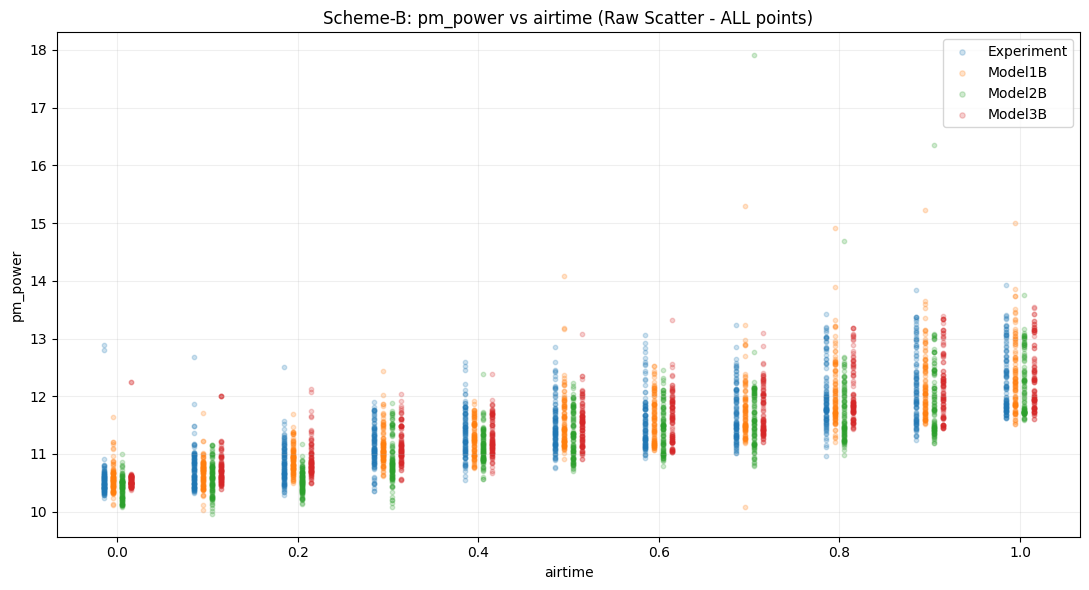

Scheme-B: pm_power vs airtime (Raw Scatter - ALL points)
Total points plotted (raw): 1159
[Model1B] MSE=0.1637 RMSE=0.4046 MAE=0.2710 MRE=2.34%
[Model2B] MSE=0.2156 RMSE=0.4643 MAE=0.3211 MRE=2.76%
[Model3B] MSE=0.1237 RMSE=0.3517 MAE=0.2444 MRE=2.13%


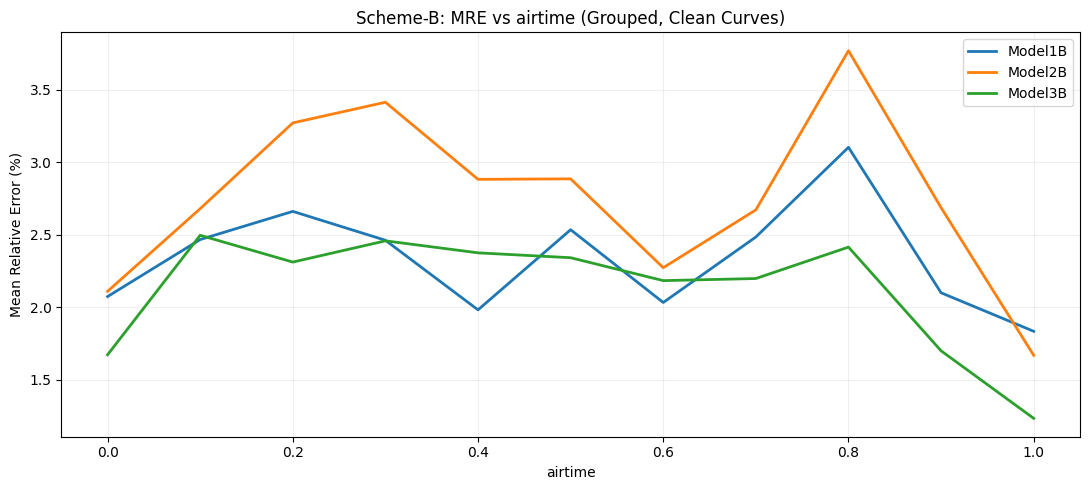

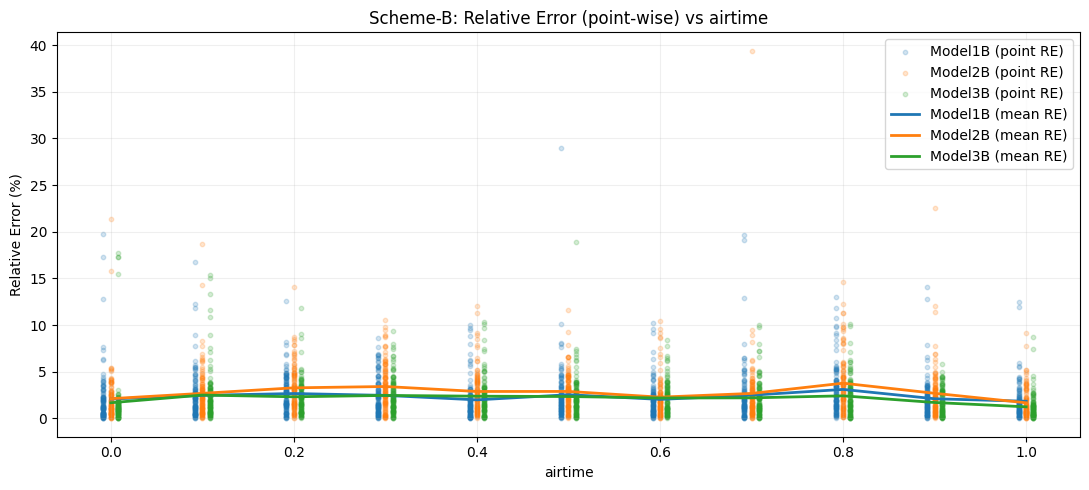

Scheme-B: Relative Error (point-wise) vs airtime
Total points: 1159
Point-RE mean:   M1=2.34% | M2=2.76% | M3=2.13%
Point-RE median: M1=1.70% | M2=2.16% | M3=1.53%


In [15]:
# ============================================================
# SCATTER (ALL POINTS) + CLEAN MRE CURVES — Scheme B
# Compare Model1B vs Model2B vs Model3B
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# ------------------------------------------------------------
# 0) Metrics
# ------------------------------------------------------------
def relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return (np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100

def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return mse, rmse, mae, mre


# ------------------------------------------------------------
# 1) Helper: robustly fetch prediction key 
# ------------------------------------------------------------
def _pick_pred_key(d, candidates):
    for k in candidates:
        if k in d:
            return k
    raise KeyError(f"Cannot find prediction key in dict. Tried: {candidates}. Keys={list(d.keys())}")

def _as_float(x):
    try:
        return float(x)
    except Exception:
        return float(np.asarray(x).item())


# ------------------------------------------------------------
# 2) Build unified raw DF for scheme B (concatenate all slices)
# ------------------------------------------------------------
def build_raw_test_dataframe_B(exp_name, xcol, test_outputs_m1B, test_outputs_m2B, test_outputs_m3B):
    """
    Scheme B: each slice_value has its own trained model + its own test set.
    We concatenate ALL slice test points into one big df_plot for scatter/MRE curves.
    """

    d_m1 = test_outputs_m1B[exp_name]
    d_m2 = test_outputs_m2B[exp_name]
    d_m3 = test_outputs_m3B[exp_name]

    def norm_map(d):
        mp = {}
        for k, v in d.items():
            mp[_as_float(k)] = v
        return mp

    m1 = norm_map(d_m1)
    m2 = norm_map(d_m2)
    m3 = norm_map(d_m3)

    common_keys = sorted(set(m1.keys()) & set(m2.keys()) & set(m3.keys()))
    if len(common_keys) == 0:
        raise ValueError(f"No common slice keys for exp={exp_name}. "
                         f"m1={len(m1)}, m2={len(m2)}, m3={len(m3)}")

    rows = []

    for s in common_keys:

        d1 = m1[s]
        d2 = m2[s]
        d3 = m3[s]

        
        k1 = _pick_pred_key(d1, ["y_pred_m1B", "y_pred_m1", "y_pred"])
        k2 = _pick_pred_key(d2, ["y_pred_m2B", "y_pred_m2", "y_pred"])
        k3 = _pick_pred_key(d3, ["y_pred_m3B", "y_pred_m3", "y_pred"])

        y_true = np.asarray(d1["y_true"]).reshape(-1)
        y_m1   = np.asarray(d1[k1]).reshape(-1)
        y_m2   = np.asarray(d2[k2]).reshape(-1)
        y_m3   = np.asarray(d3[k3]).reshape(-1)

        
        n = min(len(y_true), len(y_m1), len(y_m2), len(y_m3))
        if n == 0:
            continue
        
        y_true, y_m1, y_m2, y_m3 = y_true[:n], y_m1[:n], y_m2[:n], y_m3[:n]
        x = np.full(n, s, dtype=float)

        rows.append(pd.DataFrame({
            xcol: x,
            "y_true": y_true,
            "y_pred_m1": y_m1,
            "y_pred_m2": y_m2,
            "y_pred_m3": y_m3,
            "slice_value": s
        }))

    if len(rows) == 0:
        raise ValueError(f"Rows empty for exp={exp_name}. Possibly all slices had n==0 after alignment.")

    df_plot = pd.concat(rows, ignore_index=True)

    df_plot = df_plot.dropna(subset=[xcol, "y_true"]).copy()
    return df_plot


# ------------------------------------------------------------
# 3) Full raw scatter (ALL points) with horizontal offsets
# ------------------------------------------------------------
def plot_raw_scatter_with_offset_full(
    df_plot,
    xcol,
    title,
    offset_fraction=0.03,
    point_size=10,
    alpha=0.25,
    figsize=(11, 6)
):
    d = df_plot.dropna().copy()
    d = d.sort_values(xcol)

    x = d[xcol].to_numpy()
    x_unique = np.unique(x)
    unique_ratio = len(x_unique) / max(len(x), 1)

    # scheme B is usually discrete slices, but keep auto logic
    if len(x_unique) <= 60 or unique_ratio < 0.02:
        if len(x_unique) > 1:
            steps = np.diff(np.sort(x_unique))
            steps = steps[steps > 0]
            step = float(np.median(steps)) if len(steps) else 1.0
        else:
            step = 1.0
        dx = 0.1 * step
    else:
        x_min, x_max = float(np.min(x)), float(np.max(x))
        x_range = max(x_max - x_min, 1e-9)
        dx = offset_fraction * x_range

    offsets = {"exp": -1.5 * dx, "m1": -0.5 * dx, "m2": 0.5 * dx, "m3": 1.5 * dx}

    # metrics
    m1 = compute_metrics(d["y_true"], d["y_pred_m1"])
    m2 = compute_metrics(d["y_true"], d["y_pred_m2"])
    m3 = compute_metrics(d["y_true"], d["y_pred_m3"])

    plt.figure(figsize=figsize)
    plt.scatter(x + offsets["exp"], d["y_true"],    s=point_size, alpha=alpha, label="Experiment")
    plt.scatter(x + offsets["m1"],  d["y_pred_m1"], s=point_size, alpha=alpha, label="Model1B")
    plt.scatter(x + offsets["m2"],  d["y_pred_m2"], s=point_size, alpha=alpha, label="Model2B")
    plt.scatter(x + offsets["m3"],  d["y_pred_m3"], s=point_size, alpha=alpha, label="Model3B")

    plt.xlabel(xcol)
    plt.ylabel("pm_power")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend(markerscale=1.2, frameon=True)
    plt.tight_layout()
    plt.show()

    print("=" * 60)
    print(title)
    print(f"Total points plotted (raw): {len(d)}")
    print(f"[Model1B] MSE={m1[0]:.4f} RMSE={m1[1]:.4f} MAE={m1[2]:.4f} MRE={m1[3]:.2f}%")
    print(f"[Model2B] MSE={m2[0]:.4f} RMSE={m2[1]:.4f} MAE={m2[2]:.4f} MRE={m2[3]:.2f}%")
    print(f"[Model3B] MSE={m3[0]:.4f} RMSE={m3[1]:.4f} MAE={m3[2]:.4f} MRE={m3[3]:.2f}%")
    print("=" * 60)


# ------------------------------------------------------------
# 4) Clean MRE curves (grouped by x)
# ------------------------------------------------------------



def group_mean_mre_curve(df_plot, xcol, pred_col, eps=1e-9, min_count=1):
    d = df_plot[[xcol, "y_true", pred_col]].dropna().copy()
    d["rel_err"] = (np.abs(d["y_true"] - d[pred_col]) / (np.abs(d["y_true"]) + eps)) * 100

    g = d.groupby(xcol).agg(
        mre=("rel_err", "mean"),
        n=("rel_err", "size")
    ).reset_index()

    g = g[g["n"] >= min_count].copy()
    g = g.sort_values(xcol)
    return g


def plot_pointwise_re_scatter(
    df_plot,
    xcol,
    title,
    eps=1e-9,
    point_size=10,
    alpha=0.20,
    figsize=(11, 5),
    show_group_curve=True,
    how="mean",     # "mean" or "median"
    min_count=1
):
    """
    Point-wise Relative Error scatter:
      RE_i = |y_true_i - y_pred_i| / (|y_true_i| + eps) * 100

    show_group_curve=True will overlay grouped mean/median RE vs xcol.
    """

    d = df_plot[[xcol, "y_true", "y_pred_m1", "y_pred_m2", "y_pred_m3"]].dropna().copy()
    d = d.sort_values(xcol)

    # point-wise RE for each model
    d["re_m1"] = (np.abs(d["y_true"] - d["y_pred_m1"]) / (np.abs(d["y_true"]) + eps)) * 100
    d["re_m2"] = (np.abs(d["y_true"] - d["y_pred_m2"]) / (np.abs(d["y_true"]) + eps)) * 100
    d["re_m3"] = (np.abs(d["y_true"] - d["y_pred_m3"]) / (np.abs(d["y_true"]) + eps)) * 100

    # horizontal offsets (avoid overlap when x is discrete slices)
    x = d[xcol].to_numpy()
    x_unique = np.unique(x)
    if len(x_unique) > 1:
        steps = np.diff(np.sort(x_unique))
        steps = steps[steps > 0]
        step = float(np.median(steps)) if len(steps) else 1.0
    else:
        step = 1.0
    dx = 0.08 * step
    offsets = {"m1": -dx, "m2": 0.0, "m3": dx}

    plt.figure(figsize=figsize)
    plt.scatter(x + offsets["m1"], d["re_m1"], s=point_size, alpha=alpha, label="Model1B (point RE)")
    plt.scatter(x + offsets["m2"], d["re_m2"], s=point_size, alpha=alpha, label="Model2B (point RE)")
    plt.scatter(x + offsets["m3"], d["re_m3"], s=point_size, alpha=alpha, label="Model3B (point RE)")

    # optional grouped curve overlay
    if show_group_curve:
        if how not in ["mean", "median"]:
            raise ValueError("how must be 'mean' or 'median'")

        def _group_curve(re_col):
            g = d.groupby(xcol).agg(
                re=(re_col, how),
                n=(re_col, "size")
            ).reset_index()
            g = g[g["n"] >= min_count].sort_values(xcol)
            return g

        g1 = _group_curve("re_m1")
        g2 = _group_curve("re_m2")
        g3 = _group_curve("re_m3")

        plt.plot(g1[xcol], g1["re"], linewidth=2, label=f"Model1B ({how} RE)")
        plt.plot(g2[xcol], g2["re"], linewidth=2, label=f"Model2B ({how} RE)")
        plt.plot(g3[xcol], g3["re"], linewidth=2, label=f"Model3B ({how} RE)")

    plt.xlabel(xcol)
    plt.ylabel("Relative Error (%)")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # quick stats
    print("=" * 60)
    print(title)
    print(f"Total points: {len(d)}")
    print(f"Point-RE mean:   M1={d['re_m1'].mean():.2f}% | M2={d['re_m2'].mean():.2f}% | M3={d['re_m3'].mean():.2f}%")
    print(f"Point-RE median: M1={d['re_m1'].median():.2f}% | M2={d['re_m2'].median():.2f}% | M3={d['re_m3'].median():.2f}%")
    print("=" * 60)



def plot_mre_curves_clean(df_plot, xcol, title, min_count=1, figsize=(11, 5)):
    g1 = group_mean_mre_curve(df_plot, xcol, "y_pred_m1", min_count=min_count)
    g2 = group_mean_mre_curve(df_plot, xcol, "y_pred_m2", min_count=min_count)
    g3 = group_mean_mre_curve(df_plot, xcol, "y_pred_m3", min_count=min_count)

    plt.figure(figsize=figsize)
    plt.plot(g1[xcol], g1["mre"], label="Model1B", linewidth=2)
    plt.plot(g2[xcol], g2["mre"], label="Model2B", linewidth=2)
    plt.plot(g3[xcol], g3["mre"], label="Model3B", linewidth=2)

    plt.xlabel(xcol)
    plt.ylabel("Mean Relative Error (%)")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 5) Run plots for gain / mcs / airtime (scheme B)
# ------------------------------------------------------------
# You MUST already have:
#   test_outputs_m1B, test_outputs_m2B, test_outputs_m3B
# in memory.

PLOT_CONFIG = {
    "gain":    ("txgain",        "Scheme-B: pm_power vs txgain (Raw Scatter - ALL points)"),
    "mcs":     ("selected_mcs",  "Scheme-B: pm_power vs selected_mcs (Raw Scatter - ALL points)"),
    "airtime": ("airtime",       "Scheme-B: pm_power vs airtime (Raw Scatter - ALL points)"),
}

import inspect
print(inspect.signature(build_raw_test_dataframe_B))


for exp_name, (xcol, title) in PLOT_CONFIG.items():
    df_plot = build_raw_test_dataframe_B(
        exp_name=exp_name,
        xcol=xcol,
        test_outputs_m1B=test_outputs_m1_slices,
        test_outputs_m2B=test_outputs_m2_slices,
        test_outputs_m3B=test_outputs_m3B
    )

    plot_raw_scatter_with_offset_full(
        df_plot=df_plot,
        xcol=xcol,
        title=title,
        offset_fraction=0.02,
        point_size=10,
        alpha=0.22,
        figsize=(11, 6)
    )

    plot_mre_curves_clean(
        df_plot=df_plot,
        xcol=xcol,
        title=f"Scheme-B: MRE vs {xcol} (Grouped, Clean Curves)",
        min_count=1
    )

    plot_pointwise_re_scatter(
        df_plot=df_plot,
        xcol=xcol,
        title=f"Scheme-B: Relative Error (point-wise) vs {xcol}",
        point_size=10,
        alpha=0.20,
        figsize=(11, 5),
        show_group_curve=True,  
        how="mean",           
        min_count=1
    )

    